                       ds     y unique_id
0     2016-11-09 13:03:00   0.0   garage1
1     2016-11-09 13:04:00   0.0   garage1
2     2016-11-09 13:05:00   0.0   garage1
3     2016-11-09 13:06:00   0.0   garage1
4     2016-11-09 13:07:00   0.0   garage1
...                   ...   ...       ...
12892 2016-11-18 11:55:00  82.0   garage1
12893 2016-11-18 11:56:00  79.0   garage1
12894 2016-11-18 11:57:00  84.0   garage1
12895 2016-11-18 11:58:00  88.0   garage1
12896 2016-11-18 11:59:00  87.0   garage1

[12897 rows x 3 columns]


<Axes: xlabel='ds'>

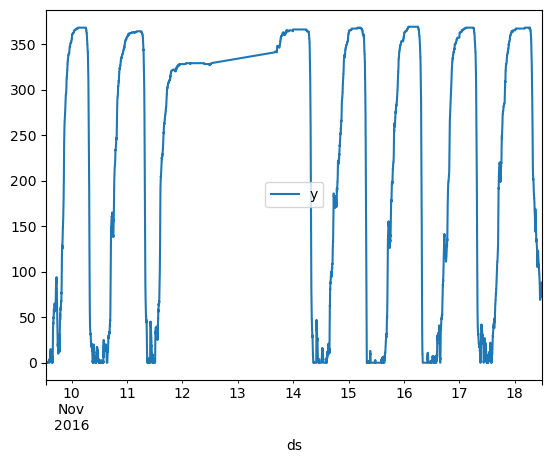

In [1]:
# Load data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path1 = 'Sign1_full_fitted.csv'
data1 = pd.read_csv(path1, usecols=[0,1], header=0)
data1['ts'] = pd.to_datetime(data1['ts'])
data1['unique_id'] = 'garage1'
data1 = data1.rename(columns={'ts': 'ds', 'y1': 'y'})
print(data1)
data1.plot(x = 'ds', y = 'y')

                       ds      y unique_id
0     2016-11-09 13:03:00    0.0   garage2
1     2016-11-09 13:04:00    0.0   garage2
2     2016-11-09 13:05:00    0.0   garage2
3     2016-11-09 13:06:00    0.0   garage2
4     2016-11-09 13:07:00    0.0   garage2
...                   ...    ...       ...
12892 2016-11-18 11:55:00  340.0   garage2
12893 2016-11-18 11:56:00  340.0   garage2
12894 2016-11-18 11:57:00  336.0   garage2
12895 2016-11-18 11:58:00  334.0   garage2
12896 2016-11-18 11:59:00  335.0   garage2

[12897 rows x 3 columns]


<Axes: xlabel='ds'>

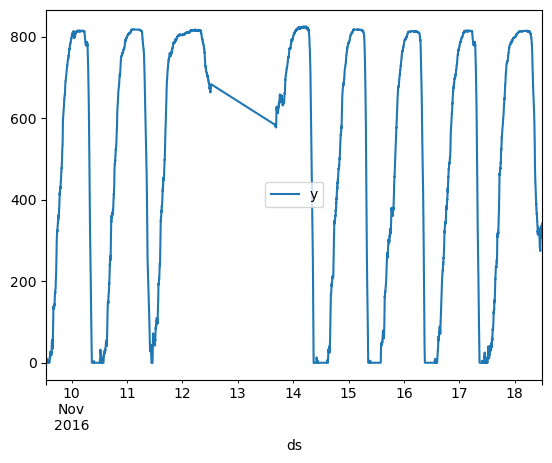

In [2]:
path2 = 'Sign12_full_fitted.csv'
data2 = pd.read_csv(path2, usecols=[0,1], header=0)
data2['ts'] = pd.to_datetime(data2['ts'])
data2['unique_id'] = 'garage2'
data2 = data2.rename(columns={'ts': 'ds', 'y12': 'y'})
print(data2)
data2.plot(x = 'ds', y = 'y')

                        ds      y unique_id
0      2016-11-09 13:03:00   20.0   garage3
1      2016-11-09 13:04:00   20.0   garage3
2      2016-11-09 13:05:00   20.0   garage3
3      2016-11-09 13:06:00   16.0   garage3
4      2016-11-09 13:07:00   16.0   garage3
...                    ...    ...       ...
12892  2016-11-18 11:55:00  333.0   garage3
12893  2016-11-18 11:56:00  334.0   garage3
12894  2016-11-18 11:57:00  335.0   garage3
12895  2016-11-18 11:58:00  336.0   garage3
12896  2016-11-18 11:59:00  335.0   garage3

[12897 rows x 3 columns]


<Axes: xlabel='ds'>

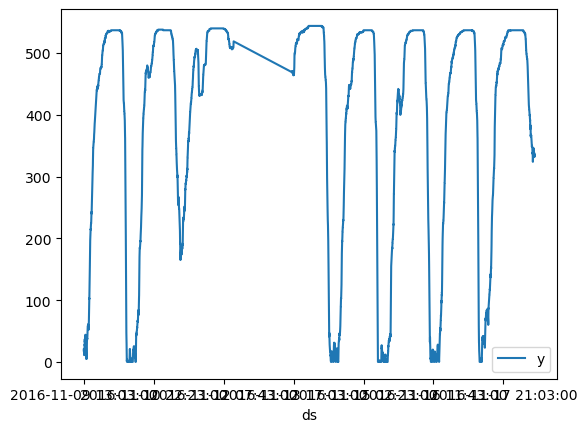

In [3]:
path3 = 'Sign14_full_fitted.csv'
data3 = pd.read_csv(path3, usecols=[0,1], header=0)
data2['ts'] = pd.to_datetime(data3['ts'])
data3['unique_id'] = 'garage3'
data3 = data3.rename(columns={'ts': 'ds', 'y14': 'y'})
print(data3)
data3.plot(x = 'ds', y = 'y')

In [4]:
df = pd.concat([data1, data2, data3])
df['ds'] = pd.to_datetime(df['ds'])
df = df.drop('ts', axis=1)

train = df.loc[df['ds'] < '2016-11-17']
valid = df.loc[(df['ds'] >= '2016-11-17')]

h = valid['ds'].nunique()

In [5]:
from lightgbm import LGBMRegressor
from mlforecast import MLForecast

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

models = [LGBMRegressor(random_state=0, n_estimators=100)]

model = MLForecast(models=models,
                   freq='T',
                   lags=[1440],
                   date_features=['dayofweek'],
                   )

model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

p = model.predict(horizon=h)
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(p['y'], p['LGBMRegressor'])

6483476715495974.0

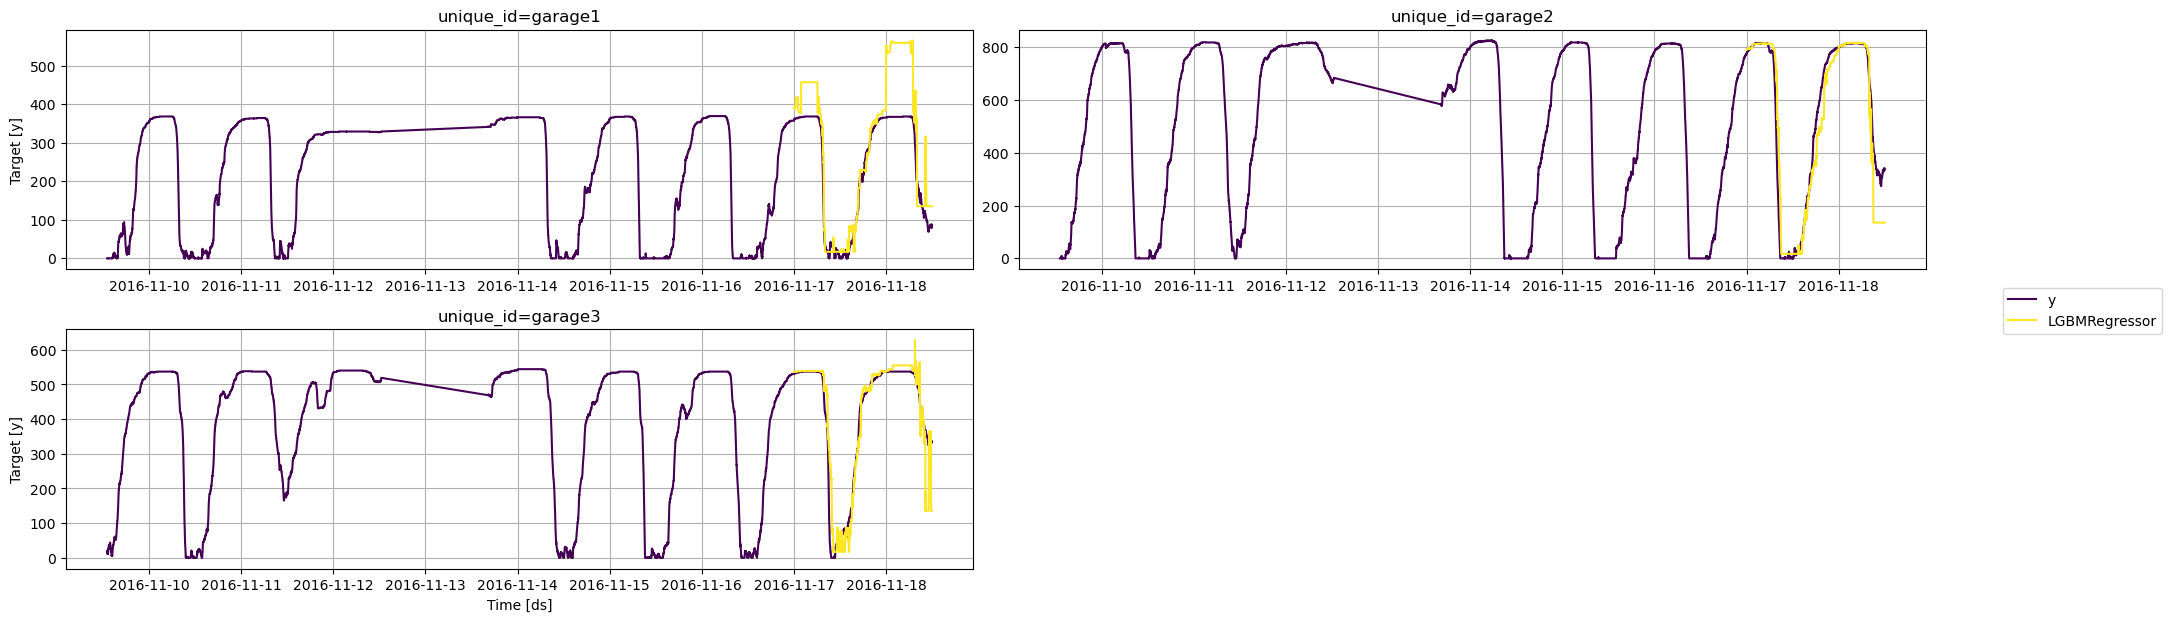

In [6]:
from utilsforecast.plotting import plot_series
fig = plot_series(train, p, max_ids=4, plot_random=False)
fig

In [11]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)
    bagging_fraction  = trial.suggest_float('bagging_fraction', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    lags = trial.suggest_int('lags', 14, 56, step=7)

    models = [LGBMRegressor(random_state=0, n_estimators=500, bagging_freq=1,
                            learning_rate=learning_rate, num_leaves=num_leaves,
                            min_data_in_leaf=min_data_in_leaf, bagging_fraction=bagging_fraction,
                            colsample_bytree=colsample_bytree)]
                            

    model = MLForecast(models=models,
                    freq='T',
                    lags=[1440],
                    date_features=['dayofweek']
                    )


    model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

    p = model.predict(horizon=h)
    p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

    error = mean_absolute_percentage_error(p['y'], p['LGBMRegressor'])
    
    return error


In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-10-16 20:13:26,296] A new study created in memory with name: no-name-d415bd6c-cee7-4401-9e72-1eb411764f25


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6545357854456476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545357854456476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:13:35,386] Trial 0 finished with value: 1.3139130556672622e+16 and parameters: {'learning_rate': 0.06855350113003145, 'num_leaves': 152, 'min_data_in_leaf': 25, 'bagging_fraction': 0.6545357854456476, 'colsample_bytree': 0.3686963747795152, 'lags': 21}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.8467953790797411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8467953790797411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:13:44,341] Trial 1 finished with value: 1.3351832409104864e+16 and parameters: {'learning_rate': 0.04471480444122963, 'num_leaves': 179, 'min_data_in_leaf': 70, 'bagging_fraction': 0.8467953790797411, 'colsample_bytree': 0.7366646696711842, 'lags': 21}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5459563443736651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5459563443736651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:13:52,817] Trial 2 finished with value: 1.7835545717704534e+16 and parameters: {'learning_rate': 0.008342833494236698, 'num_leaves': 174, 'min_data_in_leaf': 90, 'bagging_fraction': 0.5459563443736651, 'colsample_bytree': 0.2069758635468537, 'lags': 21}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_fraction is set=0.3614851046541213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3614851046541213
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:01,275] Trial 3 finished with value: 1.3860511767318108e+16 and parameters: {'learning_rate': 0.023851308306505645, 'num_leaves': 169, 'min_data_in_leaf': 68, 'bagging_fraction': 0.3614851046541213, 'colsample_bytree': 0.628029282842423, 'lags': 42}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_fraction is set=0.8242522567089968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8242522567089968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:10,444] Trial 4 finished with value: 1.3241400931053752e+16 and parameters: {'learning_rate': 0.05730654518145121, 'num_leaves': 231, 'min_data_in_leaf': 49, 'bagging_fraction': 0.8242522567089968, 'colsample_bytree': 0.12901561696709377, 'lags': 35}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.21282486317420862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21282486317420862
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:19,036] Trial 5 finished with value: 1.3309957395390596e+16 and parameters: {'learning_rate': 0.06903806936021137, 'num_leaves': 135, 'min_data_in_leaf': 25, 'bagging_fraction': 0.21282486317420862, 'colsample_bytree': 0.6670761489050747, 'lags': 14}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_fraction is set=0.8084027896014807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8084027896014807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:27,579] Trial 6 finished with value: 1.3316597314690994e+16 and parameters: {'learning_rate': 0.04739897254901887, 'num_leaves': 56, 'min_data_in_leaf': 71, 'bagging_fraction': 0.8084027896014807, 'colsample_bytree': 0.17126446857777222, 'lags': 56}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] bagging_fraction is set=0.4939713780311652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4939713780311652
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:36,098] Trial 7 finished with value: 1.3739867447066302e+16 and parameters: {'learning_rate': 0.0698188047868439, 'num_leaves': 2, 'min_data_in_leaf': 38, 'bagging_fraction': 0.4939713780311652, 'colsample_bytree': 0.8879764187478383, 'lags': 35}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_fraction is set=0.569676423546252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.569676423546252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:44,894] Trial 8 finished with value: 1.3145318905860626e+16 and parameters: {'learning_rate': 0.08612954716224448, 'num_leaves': 54, 'min_data_in_leaf': 21, 'bagging_fraction': 0.569676423546252, 'colsample_bytree': 0.6577642756919367, 'lags': 35}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_fraction is set=0.13619788773898425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13619788773898425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:14:53,326] Trial 9 finished with value: 1.338763939971878e+16 and parameters: {'learning_rate': 0.09965435540789151, 'num_leaves': 238, 'min_data_in_leaf': 53, 'bagging_fraction': 0.13619788773898425, 'colsample_bytree': 0.6385317174112087, 'lags': 49}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9935829880307693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9935829880307693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:02,296] Trial 10 finished with value: 1.3572045618263052e+16 and parameters: {'learning_rate': 0.032736723125877894, 'num_leaves': 108, 'min_data_in_leaf': 1, 'bagging_fraction': 0.9935829880307693, 'colsample_bytree': 0.40506545051169823, 'lags': 21}. Best is trial 0 with value: 1.3139130556672622e+16.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] bagging_fraction is set=0.6193104048008924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6193104048008924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:11,348] Trial 11 finished with value: 1.313634343409135e+16 and parameters: {'learning_rate': 0.08900016869395452, 'num_leaves': 61, 'min_data_in_leaf': 12, 'bagging_fraction': 0.6193104048008924, 'colsample_bytree': 0.4460393968315251, 'lags': 28}. Best is trial 11 with value: 1.313634343409135e+16.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.661318725741671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.661318725741671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:20,545] Trial 12 finished with value: 1.3110720714830914e+16 and parameters: {'learning_rate': 0.08171939514021138, 'num_leaves': 90, 'min_data_in_leaf': 1, 'bagging_fraction': 0.661318725741671, 'colsample_bytree': 0.4314547029050354, 'lags': 28}. Best is trial 12 with value: 1.3110720714830914e+16.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.6840020659615353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6840020659615353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:29,722] Trial 13 finished with value: 1.3154988756170344e+16 and parameters: {'learning_rate': 0.08984667359411297, 'num_leaves': 90, 'min_data_in_leaf': 3, 'bagging_fraction': 0.6840020659615353, 'colsample_bytree': 0.46458222152304623, 'lags': 28}. Best is trial 12 with value: 1.3110720714830914e+16.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.4353715926396925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4353715926396925
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:38,588] Trial 14 finished with value: 1.3166537707062336e+16 and parameters: {'learning_rate': 0.08035914248357845, 'num_leaves': 49, 'min_data_in_leaf': 11, 'bagging_fraction': 0.4353715926396925, 'colsample_bytree': 0.483375129580325, 'lags': 28}. Best is trial 12 with value: 1.3110720714830914e+16.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.6608833088287943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608833088287943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:47,064] Trial 15 finished with value: 1.3236307034293948e+16 and parameters: {'learning_rate': 0.09845478235548136, 'num_leaves': 4, 'min_data_in_leaf': 15, 'bagging_fraction': 0.6608833088287943, 'colsample_bytree': 0.32026938864674936, 'lags': 28}. Best is trial 12 with value: 1.3110720714830914e+16.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] bagging_fraction is set=0.39246732400039047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39246732400039047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:15:56,362] Trial 16 finished with value: 1.3091941486916704e+16 and parameters: {'learning_rate': 0.08343214069584493, 'num_leaves': 81, 'min_data_in_leaf': 37, 'bagging_fraction': 0.39246732400039047, 'colsample_bytree': 0.5170375601295041, 'lags': 42}. Best is trial 16 with value: 1.3091941486916704e+16.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.3057154337782433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3057154337782433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:16:05,525] Trial 17 finished with value: 1.3136160675387418e+16 and parameters: {'learning_rate': 0.07618894909985696, 'num_leaves': 98, 'min_data_in_leaf': 41, 'bagging_fraction': 0.3057154337782433, 'colsample_bytree': 0.5358375087291464, 'lags': 42}. Best is trial 16 with value: 1.3091941486916704e+16.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] bagging_fraction is set=0.4440579647752745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4440579647752745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:16:14,725] Trial 18 finished with value: 1.3206126359473216e+16 and parameters: {'learning_rate': 0.061374053605613536, 'num_leaves': 81, 'min_data_in_leaf': 34, 'bagging_fraction': 0.4440579647752745, 'colsample_bytree': 0.31102721286585744, 'lags': 42}. Best is trial 16 with value: 1.3091941486916704e+16.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_fraction is set=0.37007249284537846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37007249284537846
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-10-16 20:16:23,425] Trial 19 finished with value: 1.3151834358627368e+16 and parameters: {'learning_rate': 0.07806171957556342, 'num_leaves': 29, 'min_data_in_leaf': 85, 'bagging_fraction': 0.37007249284537846, 'colsample_bytree': 0.5316270034807008, 'lags': 49}. Best is trial 16 with value: 1.3091941486916704e+16.


In [13]:
study.best_params

{'learning_rate': 0.08343214069584493,
 'num_leaves': 81,
 'min_data_in_leaf': 37,
 'bagging_fraction': 0.39246732400039047,
 'colsample_bytree': 0.5170375601295041,
 'lags': 42}

In [14]:
study.best_value

1.3091941486916704e+16